# Fig: supp

**Motivation**: All supp figs. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Fig save dir

In [2]:
from figures.imgs import plot_weights

fig_dir = pjoin(fig_base_dir, 'nips_may22')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'phi_conv_categorical.png',
    'rate_dist_lca.pdf',
    'phi_lca.png',
    'phi_conv_laplace.png',
    'phi_conv_poisson.png',
    'phi_lin_laplace.png',
    'phi_fista.png',
    'phi_conv_gaussian.png',
    'phi_lin_poisson.png',
    'recons_samples',
    'phi_lin_categorical.png',
    'nelbo_point.pdf',
    'phi_lin_gaussian.png',
    'phi_ista.png',
    'rate_dist_vae.pdf'
]

## Device

In [3]:
device_idx = 1
device = f'cuda:{device_idx}'

from analysis.final import sort_fits, analyze_fits, add_nelbo_diff
from figures.table import table_entry_loss
from figures.point import nelbo_point
from analysis.stats import ttest

root = add_home('Dropbox/chkpts/PoissonVAE')

## Recon/sample MNIST

In [4]:
def accept_fn(name):
    archi = name.split('-')[1]
    accept = (
        archi == '<conv+b|conv+b>'
        and 'MNIST' in name
    )
    return accept


fits, fits_st, fits_etc = sort_fits()
fits_nonlin = sorted(filter(accept_fn, fits))
print(len(fits_nonlin))

100

In [5]:
fig_dir_recon_sample = pjoin(fig_dir, 'recons_samples')
os.listdir(fig_dir_recon_sample)

[]

categorical-10_MNIST_z-1_k-32_<conv+b|conv+b>_seed-1

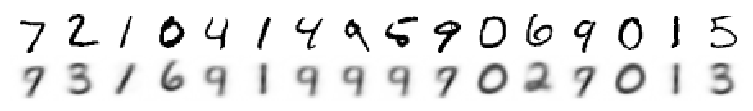

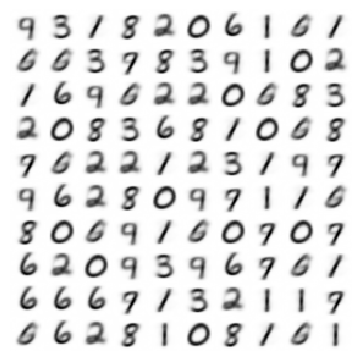

categorical-10_MNIST_z-1_k-32_<conv+b|conv+b>_seed-2

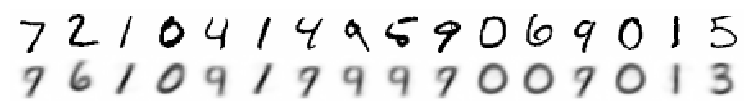

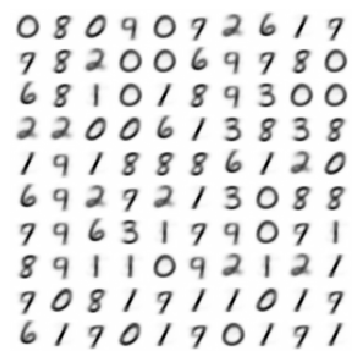

categorical-10_MNIST_z-1_k-32_<conv+b|conv+b>_seed-3

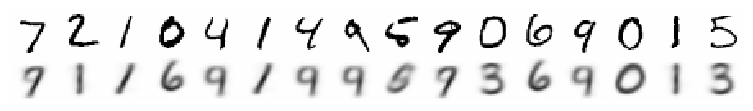

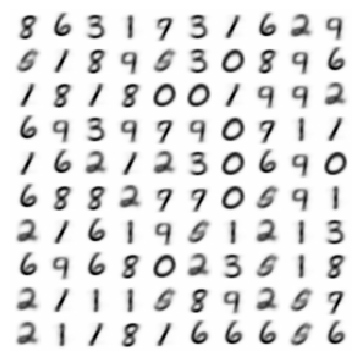

categorical-10_MNIST_z-1_k-32_<conv+b|conv+b>_seed-4

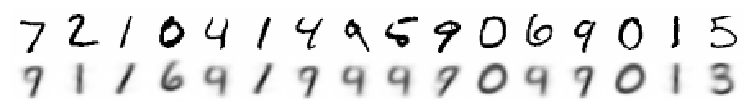

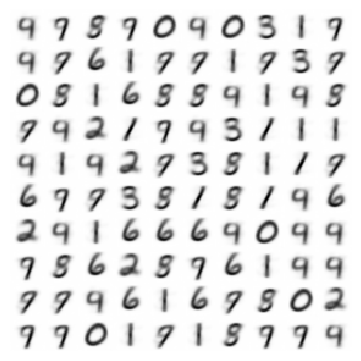

categorical-10_MNIST_z-1_k-32_<conv+b|conv+b>_seed-5

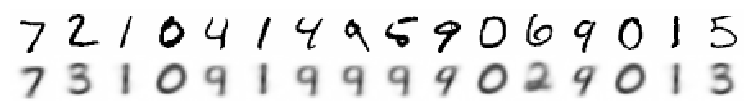

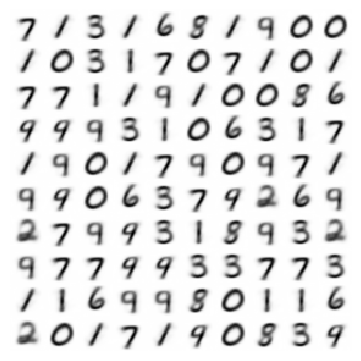

gaussian_MNIST_z-10_k-32_<conv+b|conv+b>_seed-1

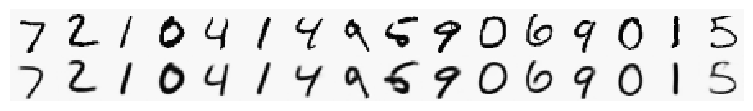

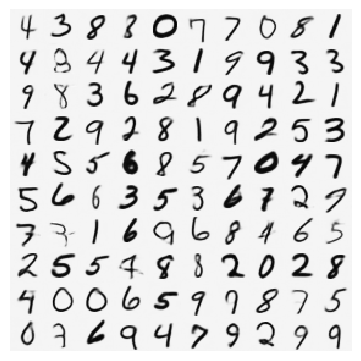

gaussian_MNIST_z-10_k-32_<conv+b|conv+b>_seed-2

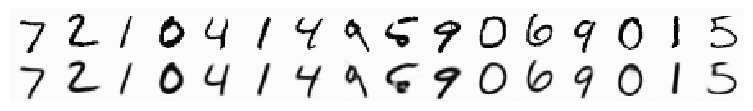

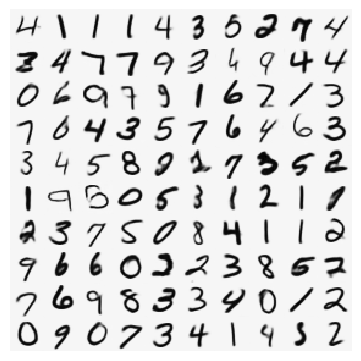

gaussian_MNIST_z-10_k-32_<conv+b|conv+b>_seed-3

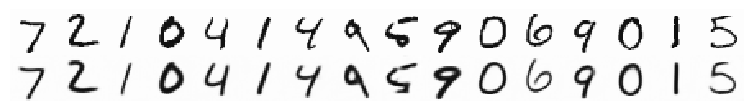

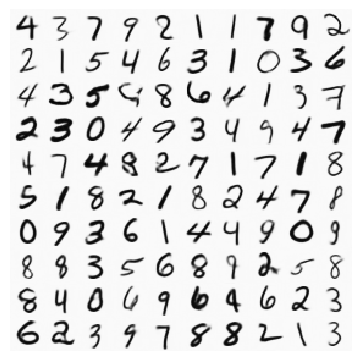

gaussian_MNIST_z-10_k-32_<conv+b|conv+b>_seed-4

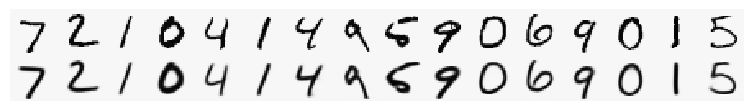

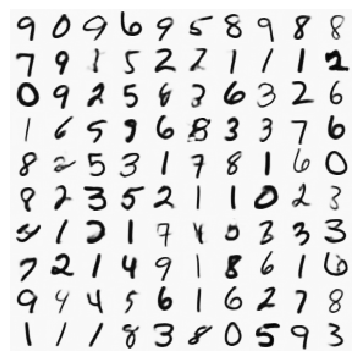

gaussian_MNIST_z-10_k-32_<conv+b|conv+b>_seed-5

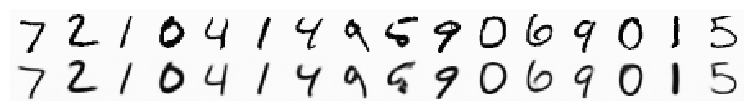

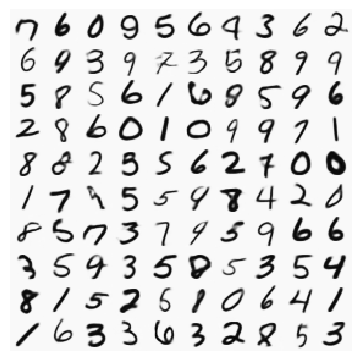

laplace_MNIST_z-10_k-32_<conv+b|conv+b>_seed-1

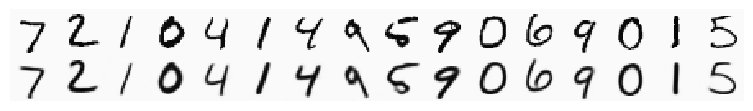

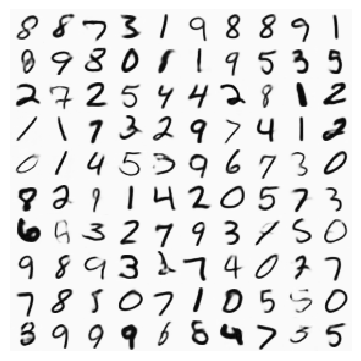

laplace_MNIST_z-10_k-32_<conv+b|conv+b>_seed-2

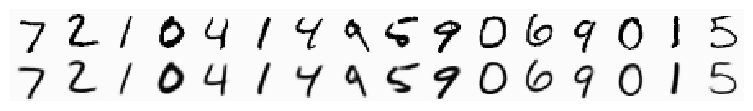

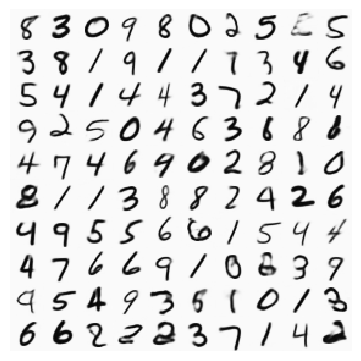

laplace_MNIST_z-10_k-32_<conv+b|conv+b>_seed-3

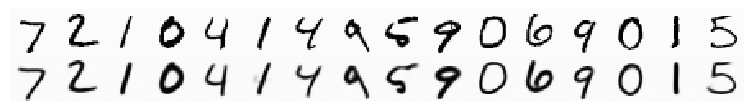

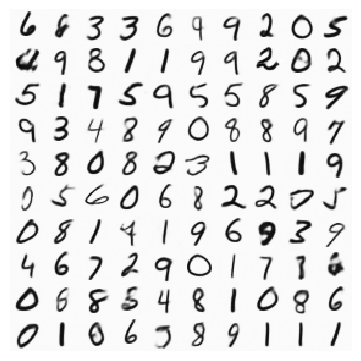

laplace_MNIST_z-10_k-32_<conv+b|conv+b>_seed-4

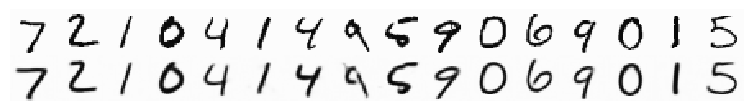

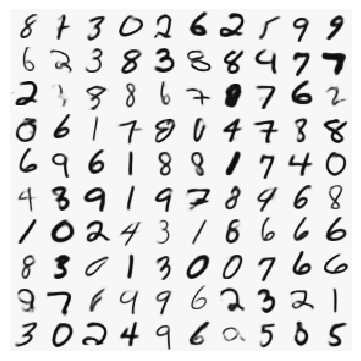

laplace_MNIST_z-10_k-32_<conv+b|conv+b>_seed-5

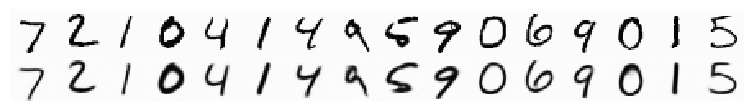

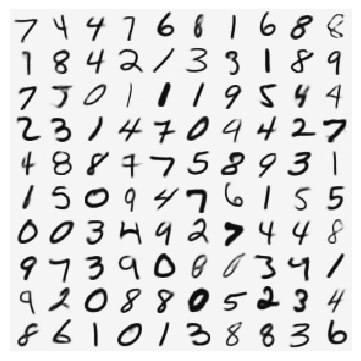

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>_seed-1

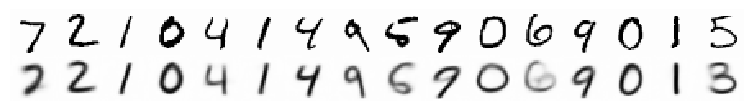

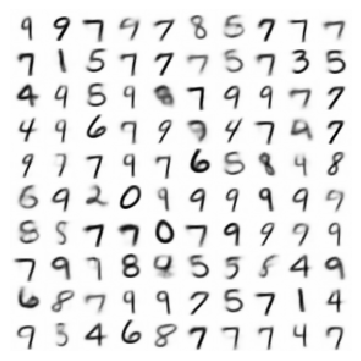

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>_seed-2

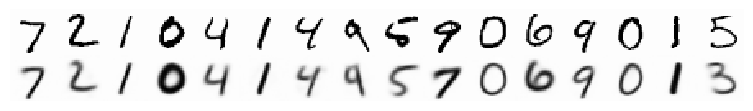

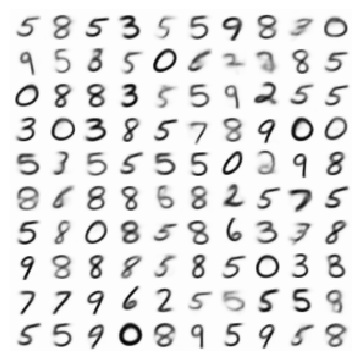

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>_seed-3

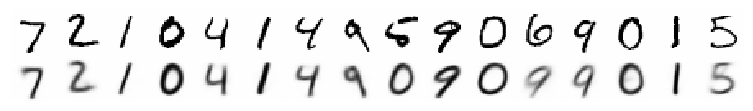

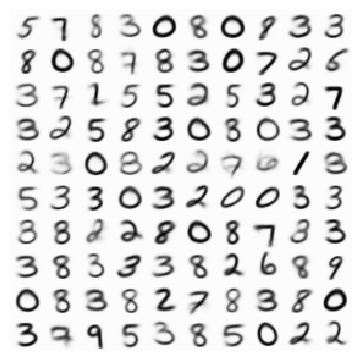

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>_seed-4

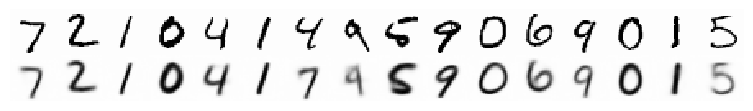

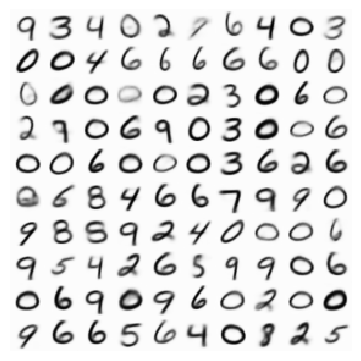

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>_seed-5

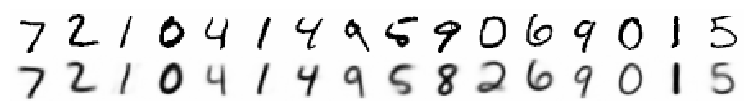

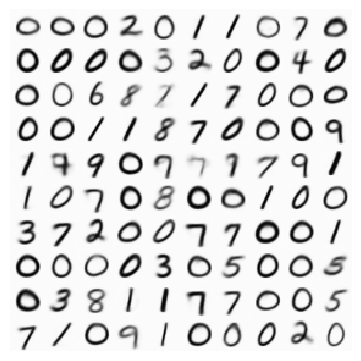

In [6]:
trainers = {}
for name in fits_nonlin:
    tr, _ = load_quick(
        pjoin(root, name),
        lite=True,
        device=device,
        verbose=False,
    )
    if tr.model.cfg.type == 'categorical':
        skip = tr.model.cfg.n_categories != 10
    else:
        skip = tr.model.cfg.n_latents != 10
    if skip:
        continue
    
    trainers[name] = tr
    print(tr.model.cfg.name())

    t = model2temp(tr.model.cfg.type)
    fig, ax = tr.show_recon(t, cmap='Greys')
    fig.savefig(pjoin(fig_dir_recon_sample, f"recon_{tr.model.cfg.name()}.png"))
    fig, ax = tr.show_samples(t, cmap='Greys')
    fig.savefig(pjoin(fig_dir_recon_sample, f"sample_{tr.model.cfg.name()}.png"))

## EX/MC/ST

In [7]:
df = pjoin(tmp_dir, 'df_main.df')
df = pd.read_pickle(df)
df = add_nelbo_diff(df)
df.shape

(150, 9)

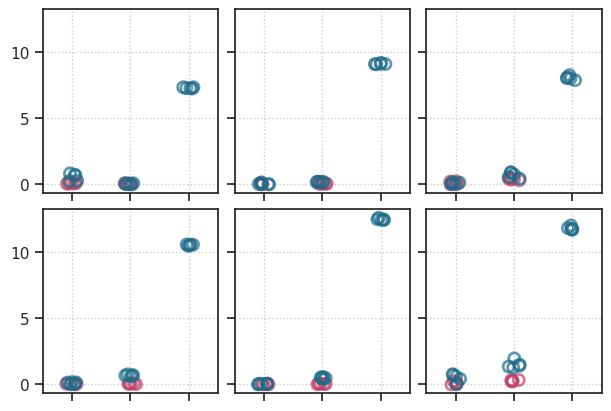

In [8]:
fig, axes = nelbo_point(df, scale=2)
fig.savefig(pjoin(fig_dir, 'nelbo_point.pdf'), **kws_fig)

## Dead neuron: KL

In [99]:
# HIDE CODE


def detect_dead_neurons(tr: TrainerVAE):
    dead_thres = {
        'poisson': 0.0082,
        'gaussian': 0.09,
        'laplace': 0.08,
    }
    data, loss, etc = tr.validate()

    if tr.model.cfg.type == 'categorical':
        thres = None
        dead = tr.model.find_dead_neurons(1)
    else:
        thres = dead_thres.get(tr.model.cfg.type)
        dead = loss['kl_diag'] < thres
    return data, loss, etc, thres, dead.astype(bool)

In [100]:
models2load = {
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [101]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 394.2 K

# params: 262.7 K

# params: 394.2 K

# params: 262.7 K

In [102]:
bins = {
    'poisson': np.linspace(0, 111 / 1000, 112),
    'gaussian': np.linspace(0, 80 / 100, 81),
    'laplace': np.linspace(0, 80 / 100, 81),
}

In [105]:
pal = get_palette()[0]

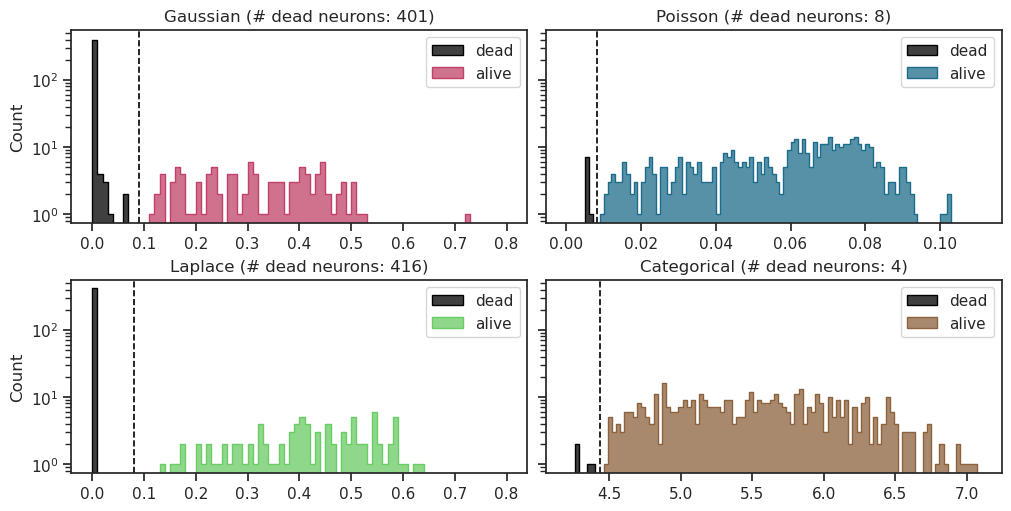

In [110]:
fig, axes = create_figure(2, 2, (10, 5), sharey='all')

for idx, (name, tr) in enumerate(trainers.items()):
    color = pal[name]
    data, loss, etc, thres, dead = detect_dead_neurons(tr)
    ax = axes.flat[idx]
    if name == 'categorical':
        norms = tonp(torch.linalg.vector_norm(
        tr.model.fc_dec.weight.data, dim=0))
        thres = 4.435
        dead = norms < thres

        sns.histplot(norms[dead], bins=np.linspace(4.2, 7.1, 101), color='k', label='dead', element='step', ax=ax)
        sns.histplot(norms[~dead], bins=np.linspace(4.2, 7.1, 101), color=color, label='alive', element='step', ax=ax)

    else:
        sns.histplot(loss['kl_diag'][dead], bins=bins[name], color='k', label='dead', element='step', ax=ax)
        sns.histplot(loss['kl_diag'][~dead], bins=bins[name], color=color, label='alive', element='step', ax=ax)

    ax.axvline(thres, color='k', ls='--', lw=1.2)

    ax.locator_params(axis='x', nbins=11)
    ax.set_title(f"{name.capitalize()} (# dead neurons: {dead.sum()})")
    ax.set_yscale('log')
axes[0, 1].set(ylabel='')
axes[1, 1].set(ylabel='')
add_legend(axes)
plt.show()

In [111]:
fig.savefig(pjoin(fig_dir, 'dead_kl_gap.pdf'), **kws_fig)